# Plot RPN loss probe output

In [95]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load tensors

In [96]:
# Load tensors
# savepath = 'probe/probe_loss_out_val.pt'
# gtsavepath = 'probe/gt_boxes_val.pt'
savepath = 'probe/probe_loss_out_train50000.pt'
gtsavepath = 'probe/gt_boxes_train50000.pt'
total = torch.load(savepath, map_location='cpu')
gts = torch.load(gtsavepath, map_location='cpu')
print("total:",total.shape)
print("gts:", gts.shape)

total: torch.Size([3273315, 7])
gts: torch.Size([360447, 4])


## Define histogram bins

In [98]:
# Set histogram/bar bins
max_sqrt_area = 1030
sqrt_area_bins = list(range(0, max_sqrt_area, 5))

# Compute sqrt_areas = sqrt(widths * heights)
sqrt_areas = torch.sqrt((total[:, 2] - total[:, 0]) * (total[:, 3] - total[:, 1]))
print("sqrt_areas:", sqrt_areas, sqrt_areas.min(), sqrt_areas.max(), sqrt_areas.shape)
sqrt_areas_gt = torch.sqrt((gts[:, 2] - gts[:, 0]) * (gts[:, 3] - gts[:, 1]))
#print("sqrt_areas_gt:", sqrt_areas_gt, sqrt_areas_gt.min(), sqrt_areas_gt.max(), sqrt_areas_gt.shape)

sqrt_areas: tensor([135.0479, 135.0479, 135.0479,  ..., 657.9717, 657.9717, 657.9717]) tensor(0.7163) tensor(1029.2224) torch.Size([3273315])


## Plot instance counts based on object size

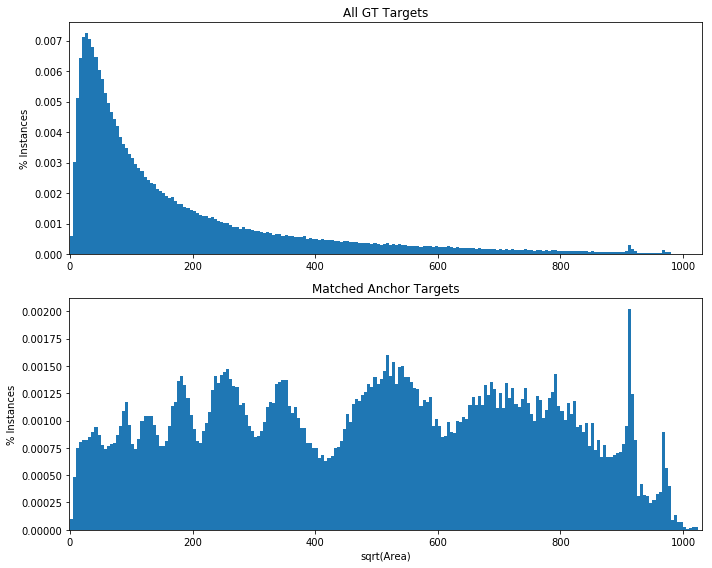

In [99]:
# Plot instance count histograms
fig, axs = plt.subplots(2, 1, figsize=(10,8))
axs[0].hist(sqrt_areas_gt, sqrt_area_bins, density=True)
axs[0].set_title('All GT Targets')
axs[0].set_xlim(left=-1, right=max_sqrt_area+1)
axs[0].set_ylabel('% Instances')

axs[1].hist(sqrt_areas, sqrt_area_bins, density=True)
axs[1].set_title('Matched Anchor Targets')
axs[1].set_xlim(left=-1, right=max_sqrt_area+1)
axs[1].set_ylabel('% Instances')
axs[1].set_xlabel('sqrt(Area)')

fig.tight_layout()
plt.show()

## Accumulate losses over object size bins

In [100]:
### Accumulate losses over attributes
bins = sqrt_area_bins
accumulated_losses_sum = []
accumulated_losses_cls_sum = []
accumulated_losses_reg_sum = []
accumulated_losses_avg = []
accumulated_losses_cls_avg = []
accumulated_losses_reg_avg = []
losses = total[:, -2:]
losses_cls = losses[:, 0]
losses_reg = losses[:, 1]
#print("losses:", losses.shape)
#print("sqrt_areas:", sqrt_areas.shape)
sum_losses_sum = 0
#sum_losses_cls_sum = 0
#sum_losses_reg_sum = 0
sum_losses_avg = 0
#sum_losses_cls_avg = 0
#sum_losses_reg_avg = 0

for i in range(len(bins) - 1):
    # Make binary mask for current bin
    # Note: element-wise multiplication of binary tensors is == element-wise 'and'
    mask = (sqrt_areas >= bins[i]) * (sqrt_areas < bins[i+1])
    num_boxes = mask.sum().item()
    # Slice out losses from boxes that are in this bin
    curr_losses = losses[mask.nonzero()].squeeze()
    curr_losses_cls = losses_cls[mask.nonzero()].squeeze()
    curr_losses_reg = losses_reg[mask.nonzero()].squeeze()
    # Accumulate losses
    curr_acc_loss_sum = curr_losses.sum().item()
    curr_acc_loss_cls_sum = curr_losses_cls.sum().item()
    curr_acc_loss_reg_sum = curr_losses_reg.sum().item()
    curr_acc_loss_avg = curr_acc_loss_sum / num_boxes if num_boxes > 0 else 0
    curr_acc_loss_cls_avg = curr_acc_loss_cls_sum / num_boxes if num_boxes > 0 else 0
    curr_acc_loss_reg_avg = curr_acc_loss_reg_sum / num_boxes if num_boxes > 0 else 0
    # Append current accumulated loss to accumulated_losses list
    accumulated_losses_sum.append(curr_acc_loss_sum)
    accumulated_losses_cls_sum.append(curr_acc_loss_cls_sum)
    accumulated_losses_reg_sum.append(curr_acc_loss_reg_sum)
    accumulated_losses_avg.append(curr_acc_loss_avg)
    accumulated_losses_cls_avg.append(curr_acc_loss_cls_avg)
    accumulated_losses_reg_avg.append(curr_acc_loss_reg_avg)
    # Add to sums
    sum_losses_sum += curr_acc_loss_sum
    #sum_losses_cls_sum += curr_acc_loss_cls_sum
    #sum_losses_reg_sum += curr_acc_loss_reg_sum
    sum_losses_avg += curr_acc_loss_avg
    #sum_losses_cls_avg += curr_acc_loss_cls_avg
    #sum_losses_reg_avg += curr_acc_loss_reg_avg
    
# Make accumulated_losses a torch tensor
accumulated_losses_sum = torch.tensor(accumulated_losses_sum)
accumulated_losses_cls_sum = torch.tensor(accumulated_losses_cls_sum)
accumulated_losses_reg_sum = torch.tensor(accumulated_losses_reg_sum)
accumulated_losses_avg = torch.tensor(accumulated_losses_avg)
accumulated_losses_cls_avg = torch.tensor(accumulated_losses_cls_avg)
accumulated_losses_reg_avg = torch.tensor(accumulated_losses_reg_avg)

# Normalize accumulated_losses so that they sum to 1
# Note: cls and reg are normalized by the total sum
norm_accumulated_losses_sum = accumulated_losses_sum / sum_losses_sum
norm_accumulated_losses_cls_sum = accumulated_losses_cls_sum / sum_losses_sum #sum_losses_cls_sum
norm_accumulated_losses_reg_sum = accumulated_losses_reg_sum / sum_losses_sum #sum_losses_reg_sum
norm_accumulated_losses_avg = accumulated_losses_avg / sum_losses_avg
norm_accumulated_losses_cls_avg = accumulated_losses_cls_avg / sum_losses_avg #sum_losses_cls_avg
norm_accumulated_losses_reg_avg = accumulated_losses_reg_avg / sum_losses_avg #sum_losses_reg_avg

print("norm_accumulated_losses_sum:", norm_accumulated_losses_sum.sum())
print("norm_accumulated_losses_cls_sum:", norm_accumulated_losses_cls_sum.sum())
print("norm_accumulated_losses_reg_sum:", norm_accumulated_losses_reg_sum.sum())

norm_accumulated_losses_sum: tensor(1.)
norm_accumulated_losses_cls_sum: tensor(0.6778)
norm_accumulated_losses_reg_sum: tensor(0.3222)


## Plot bar charts of loss contribution

Note: Only plot combined loss (bbox + reg)

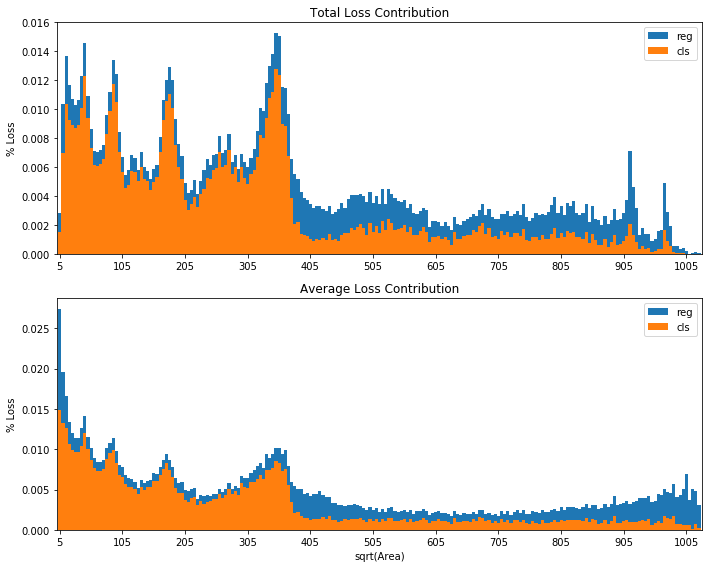

In [101]:
### Plot bar chart
# Create x_ticks and tick labels
x = torch.arange(len(norm_accumulated_losses_sum))
x_ticks = torch.arange(0, len(bins), step=20)
bins_t = torch.tensor(bins)
bin_labels = bins_t[1:][x_ticks].tolist()
bin_labels = [str(b) for b in bin_labels]


fig, axs = plt.subplots(2, 1, figsize=(10,8))
#axs[0].bar(x, norm_accumulated_losses_sum, width=1.0)
axs[0].bar(x, norm_accumulated_losses_reg_sum, bottom=norm_accumulated_losses_cls_sum, width=1.0, label='reg')
axs[0].bar(x, norm_accumulated_losses_cls_sum, width=1.0, label='cls')
axs[0].set_title('Total Loss Contribution')
axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(bin_labels)
axs[0].set_xlim(x[0]-1, x[-1]+1)
axs[0].set_ylabel('% Loss')
axs[0].legend()

#axs[1].bar(x, norm_accumulated_losses_avg, width=1.0)
axs[1].bar(x, norm_accumulated_losses_reg_avg, bottom=norm_accumulated_losses_cls_avg, width=1.0, label='reg')
axs[1].bar(x, norm_accumulated_losses_cls_avg, width=1.0, label='cls')
axs[1].set_title('Average Loss Contribution')
axs[1].set_xticks(x_ticks)
axs[1].set_xticklabels(bin_labels)
axs[1].set_xlim(x[0]-1, x[-1]+1)
axs[1].set_xlabel('sqrt(Area)')
axs[1].set_ylabel('% Loss')
axs[1].legend()

fig.tight_layout()
plt.show()

## Plot CDF of loss contribution

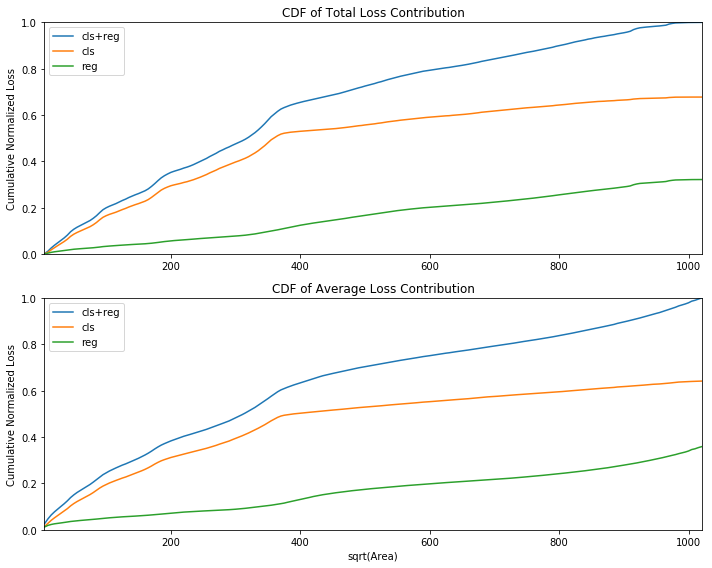

In [84]:
# First, create cumulative loss arrays
cumulative_losses_sum = []
cumulative_losses_cls_sum = []
cumulative_losses_reg_sum = []
cumulative_losses_avg = []
cumulative_losses_cls_avg = []
cumulative_losses_reg_avg = []

running_sum_sum = 0
running_sum_cls_sum = 0
running_sum_reg_sum = 0
running_sum_avg = 0
running_sum_cls_avg = 0
running_sum_reg_avg = 0

for i in range(len(norm_accumulated_losses_sum)):
    # Update running sums
    running_sum_sum += norm_accumulated_losses_sum[i].item()
    running_sum_cls_sum += norm_accumulated_losses_cls_sum[i].item()
    running_sum_reg_sum += norm_accumulated_losses_reg_sum[i].item()
    running_sum_avg += norm_accumulated_losses_avg[i].item()
    running_sum_cls_avg += norm_accumulated_losses_cls_avg[i].item()
    running_sum_reg_avg += norm_accumulated_losses_reg_avg[i].item()
    # Append current running sum to lists
    cumulative_losses_sum.append(running_sum_sum)
    cumulative_losses_cls_sum.append(running_sum_cls_sum)
    cumulative_losses_reg_sum.append(running_sum_reg_sum)
    cumulative_losses_avg.append(running_sum_avg)
    cumulative_losses_cls_avg.append(running_sum_cls_avg)
    cumulative_losses_reg_avg.append(running_sum_reg_avg)
    
# Plot CDF lines
fig, axs = plt.subplots(2, 1, figsize=(10,8))
axs[0].plot(bins[1:], cumulative_losses_sum, label='cls+reg')
axs[0].plot(bins[1:], cumulative_losses_cls_sum, label='cls')
axs[0].plot(bins[1:], cumulative_losses_reg_sum, label='reg')
axs[0].set_title('CDF of Total Loss Contribution')
axs[0].set_xlim(bins[1:][0]-1, bins[1:][-1]+1)
axs[0].set_ylim(0, 1.0)
axs[0].set_ylabel('Cumulative Normalized Loss')
axs[0].legend()

axs[1].plot(bins[1:], cumulative_losses_avg, label='cls+reg')
axs[1].plot(bins[1:], cumulative_losses_cls_avg, label='cls')
axs[1].plot(bins[1:], cumulative_losses_reg_avg, label='reg')
axs[1].set_title('CDF of Average Loss Contribution')
axs[1].set_xlim(bins[1:][0]-1, bins[1:][-1]+1)
axs[1].set_ylim(0, 1.0)
axs[1].set_xlabel('sqrt(Area)')
axs[1].set_ylabel('Cumulative Normalized Loss')
axs[1].legend()

fig.tight_layout()
plt.show()